# Rock Estate - Technical assessment

Done by <a href="https://www.luismiguellara.com">Luis Lara</a>

In [112]:
!pip install folium
!pip install ipyleaflet #requires nodeJS
!pip install geopandas
!pip install ipyleaflet
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import requests
import os
from io import BytesIO
import zipfile
import shutil
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ERROR: Invalid requirement: '#requires': Expected package name at the start of dependency specifier
    #requires
    ^


## ETL

In [ ]:
current_dir = os.getcwd() # <- for iPython, os.path.dirname(__file__) on CPython
temp_dir = os.path.join(current_dir, "temp")
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    
os.mkdir(temp_dir)

### Working with the real estate data

In [8]:
response = requests.get("https://statbel.fgov.be/sites/default/files/files/documents/Bouwen%20%26%20wonen/2.1%20Vastgoedprijzen/NM/FR_immo_statbel_trimestre_par_commune.xlsx")
df = pd.read_excel(BytesIO(response.content), skiprows=2)
df.head()

,refnis,localité,année,période,Unnamed: 4,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€),Unnamed: 9,...,prix troisième quartile(€).2,Unnamed: 19,nombre transactions.3,prix médian(€).3,prix premier quartile(€).3,prix troisième quartile(€).3,Unnamed: 24,Unnamed: 25,Unnamed: 26,0
0,11001,AARTSELAAR,2010,Q1,NaN,29.0,252000.0,225000.0,290000.0,NaN,...,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,11001,AARTSELAAR,2010,Q2,NaN,25.0,254000.0,212000.0,289000.0,NaN,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2,11001,AARTSELAAR,2010,Q3,NaN,21.0,255000.0,235000.0,285000.0,NaN,...,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,11001,AARTSELAAR,2010,Q4,NaN,28.0,245000.0,210000.0,312500.0,NaN,...,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,11001,AARTSELAAR,2011,Q1,NaN,23.0,310000.0,220000.0,370000.0,NaN,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1


In [9]:
df["quarter"] = df["année"].astype(str).fillna("") +  df["période"]
df.head()

,refnis,localité,année,période,Unnamed: 4,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€),Unnamed: 9,...,Unnamed: 19,nombre transactions.3,prix médian(€).3,prix premier quartile(€).3,prix troisième quartile(€).3,Unnamed: 24,Unnamed: 25,Unnamed: 26,0,quarter
0,11001,AARTSELAAR,2010,Q1,NaN,29.0,252000.0,225000.0,290000.0,NaN,...,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2010Q1
1,11001,AARTSELAAR,2010,Q2,NaN,25.0,254000.0,212000.0,289000.0,NaN,...,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2010Q2
2,11001,AARTSELAAR,2010,Q3,NaN,21.0,255000.0,235000.0,285000.0,NaN,...,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2010Q3
3,11001,AARTSELAAR,2010,Q4,NaN,28.0,245000.0,210000.0,312500.0,NaN,...,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2010Q4
4,11001,AARTSELAAR,2011,Q1,NaN,23.0,310000.0,220000.0,370000.0,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2011Q1


In [10]:
df_temp1 = df.copy()[["refnis", "année", "période", "quarter"]]   
df_temp2 = df.copy().iloc[:, 5:9] 
df_all_houses =  pd.concat([df_temp1, df_temp2], axis=1)
df_all_houses.columns = [c.split(".")[0].strip() for c in df_all_houses.columns]
df_all_houses

,refnis,année,période,quarter,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€)
0,11001,2010,Q1,2010Q1,29.0,252000.0,225000.0,290000.0
1,11001,2010,Q2,2010Q2,25.0,254000.0,212000.0,289000.0
2,11001,2010,Q3,2010Q3,21.0,255000.0,235000.0,285000.0
3,11001,2010,Q4,2010Q4,28.0,245000.0,210000.0,312500.0
4,11001,2011,Q1,2011Q1,23.0,310000.0,220000.0,370000.0
...,...,...,...,...,...,...,...,...
34460,93090,2024,Q1,2024Q1,25.0,130000.0,100000.0,176000.0
34461,93090,2024,Q2,2024Q2,19.0,120000.0,53000.0,200000.0
34462,93090,2024,Q3,2024Q3,16.0,NaN,NaN,NaN
34463,93090,2024,Q4,2024Q4,33.0,125000.0,88000.0,174000.0


In [11]:
df_temp1 = df.copy()[["refnis", "année", "période", "quarter"]]   
df_temp2 = df.copy().iloc[:, 10:14] 
df_attached_houses =  pd.concat([df_temp1, df_temp2], axis=1)
df_attached_houses.columns = [c.split(".")[0].strip() for c in df_attached_houses.columns]
df_attached_houses

,refnis,année,période,quarter,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€)
0,11001,2010,Q1,2010Q1,25.0,247000.0,220000.0,265000.0
1,11001,2010,Q2,2010Q2,20.0,251250.0,209000.0,275000.0
2,11001,2010,Q3,2010Q3,18.0,250000.0,230000.0,275000.0
3,11001,2010,Q4,2010Q4,21.0,245000.0,205000.0,280000.0
4,11001,2011,Q1,2011Q1,18.0,280000.0,220000.0,360000.0
...,...,...,...,...,...,...,...,...
34460,93090,2024,Q1,2024Q1,18.0,121500.0,90000.0,135000.0
34461,93090,2024,Q2,2024Q2,10.0,NaN,NaN,NaN
34462,93090,2024,Q3,2024Q3,9.0,NaN,NaN,NaN
34463,93090,2024,Q4,2024Q4,19.0,117500.0,88000.0,136000.0


In [12]:
df_temp1 = df.copy()[["refnis", "année", "période", "quarter"]]   
df_temp2 = df.copy().iloc[:, 15:19] 
df_dettached_houses =  pd.concat([df_temp1, df_temp2], axis=1)
df_dettached_houses.columns = [c.split(".")[0].strip() for c in df_dettached_houses.columns]
df_dettached_houses

,refnis,année,période,quarter,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€)
0,11001,2010,Q1,2010Q1,4.0,NaN,NaN,NaN
1,11001,2010,Q2,2010Q2,5.0,NaN,NaN,NaN
2,11001,2010,Q3,2010Q3,3.0,NaN,NaN,NaN
3,11001,2010,Q4,2010Q4,7.0,NaN,NaN,NaN
4,11001,2011,Q1,2011Q1,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
34460,93090,2024,Q1,2024Q1,7.0,NaN,NaN,NaN
34461,93090,2024,Q2,2024Q2,9.0,NaN,NaN,NaN
34462,93090,2024,Q3,2024Q3,7.0,NaN,NaN,NaN
34463,93090,2024,Q4,2024Q4,14.0,NaN,NaN,NaN


In [13]:
df_temp1 = df.copy()[["refnis", "année", "période", "quarter"]]   
df_temp2 = df.copy().iloc[:, 20:24] 
df_all_appartments =  pd.concat([df_temp1, df_temp2], axis=1)
df_all_appartments.columns = [c.split(".")[0].strip() for c in df_all_appartments.columns]
df_all_appartments.head(10)

,refnis,année,période,quarter,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€)
0,11001,2010,Q1,2010Q1,9.0,NaN,NaN,NaN
1,11001,2010,Q2,2010Q2,11.0,NaN,NaN,NaN
2,11001,2010,Q3,2010Q3,9.0,NaN,NaN,NaN
3,11001,2010,Q4,2010Q4,13.0,NaN,NaN,NaN
4,11001,2011,Q1,2011Q1,10.0,NaN,NaN,NaN
5,11001,2011,Q2,2011Q2,16.0,148750.0,140000.0,158000.0
6,11001,2011,Q3,2011Q3,8.0,NaN,NaN,NaN
7,11001,2011,Q4,2011Q4,10.0,NaN,NaN,NaN
8,11001,2012,Q1,2012Q1,12.0,NaN,NaN,NaN
9,11001,2012,Q2,2012Q2,21.0,165000.0,150000.0,214000.0


In [14]:
df_all_appartments.describe()

,refnis,année,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€)
count,34465.000000,34465.000000,25577.000000,5572.000000,5572.000000,5572.000000
mean,47214.663717,2017.131148,21.676702,196911.367911,154225.367732,251586.375808
std,24353.189501,4.403771,74.152933,54685.887479,42925.621821,78045.260963
min,11001.000000,2010.000000,1.000000,35000.000000,18000.000000,53000.000000
25%,24104.000000,2013.000000,2.000000,160000.000000,124500.000000,200000.000000
50%,45062.000000,2017.000000,5.000000,189000.000000,150000.000000,240000.000000
75%,63075.000000,2021.000000,14.000000,225000.000000,180000.000000,285000.000000
max,93090.000000,2025.000000,2103.000000,600000.000000,400000.000000,930500.000000


### Fixing missing data

In [15]:
def fill_data(df_obj):
    df_obj['prix médian(€)'] = df_obj.groupby('refnis')['prix médian(€)'].transform(lambda x: x.interpolate(method='linear'))
    df_obj['prix médian(€)'] = df_obj['prix médian(€)'].bfill().interpolate(method='linear')
    return df_obj
    
df_all_houses = fill_data(df_all_houses)
df_attached_houses = fill_data(df_attached_houses) 
df_dettached_houses = fill_data(df_dettached_houses) 
df_all_appartments = fill_data(df_all_appartments) 
df_all_appartments                          

,refnis,année,période,quarter,nombre transactions,prix médian(€),prix premier quartile(€),prix troisième quartile(€)
0,11001,2010,Q1,2010Q1,9.0,148750.0,NaN,NaN
1,11001,2010,Q2,2010Q2,11.0,148750.0,NaN,NaN
2,11001,2010,Q3,2010Q3,9.0,148750.0,NaN,NaN
3,11001,2010,Q4,2010Q4,13.0,148750.0,NaN,NaN
4,11001,2011,Q1,2011Q1,10.0,148750.0,NaN,NaN
...,...,...,...,...,...,...,...,...
34460,93090,2024,Q1,2024Q1,NaN,265000.0,NaN,NaN
34461,93090,2024,Q2,2024Q2,6.0,265000.0,NaN,NaN
34462,93090,2024,Q3,2024Q3,NaN,265000.0,NaN,NaN
34463,93090,2024,Q4,2024Q4,NaN,265000.0,NaN,NaN


## Analysing Geodata

In [16]:
response = requests.get("https://statbel.fgov.be/sites/default/files/files/opendata/Statistische%20sectoren/sh_statbel_statistical_sectors_31370_20240101.sqlite.zip")
zip_file = zipfile.ZipFile(BytesIO(response.content))
files = zip_file.namelist()
files

['sh_statbel_statistical_sectors_31370_20240101.sqlite/Licence open data_FR.pdf',
 'sh_statbel_statistical_sectors_31370_20240101.sqlite/Licence open data_NL.pdf',
 'sh_statbel_statistical_sectors_31370_20240101.sqlite/sh_statbel_statistical_sectors_31370_20240101.sqlite',
 'sh_statbel_statistical_sectors_31370_20240101.sqlite/sh_statbel_statistical_sectors_31370_20240101-readme-de.doc',
 'sh_statbel_statistical_sectors_31370_20240101.sqlite/sh_statbel_statistical_sectors_31370_20240101-readme-en.doc',
 'sh_statbel_statistical_sectors_31370_20240101.sqlite/sh_statbel_statistical_sectors_31370_20240101-readme-fr.doc',
 'sh_statbel_statistical_sectors_31370_20240101.sqlite/sh_statbel_statistical_sectors_31370_20240101-readme-nl.doc']

In [17]:
db_full_path = [f for f in files if f.endswith(".sqlite")][0]
db_name = os.path.basename(db_full_path)
with open(os.path.join("temp", db_name), "wb") as f_out:
    f_out.write(zip_file.read(db_full_path))

In [18]:
conn = sqlite3.connect("temp/sh_statbel_statistical_sectors_31370_20240101.sqlite")
df_table_names = pd.read_sql("SELECT * FROM sqlite_master WHERE type='table'", con=conn)
df_table_names

,type,name,tbl_name,rootpage,sql
0,table,spatial_ref_sys,spatial_ref_sys,2,CREATE TABLE spatial_ref_sys (\nsrid INTEGER N...
1,table,spatialite_history,spatialite_history,4,CREATE TABLE spatialite_history (\nevent_id IN...
2,table,sqlite_sequence,sqlite_sequence,5,"CREATE TABLE sqlite_sequence(name,seq)"
3,table,geometry_columns,geometry_columns,6,CREATE TABLE geometry_columns (\nf_table_name ...
4,table,spatial_ref_sys_aux,spatial_ref_sys_aux,11,CREATE TABLE spatial_ref_sys_aux (\n\tsrid INT...
5,table,views_geometry_columns,views_geometry_columns,1319,CREATE TABLE views_geometry_columns (\nview_na...
6,table,virts_geometry_columns,virts_geometry_columns,1325,CREATE TABLE virts_geometry_columns (\nvirt_na...
7,table,geometry_columns_statistics,geometry_columns_statistics,1329,CREATE TABLE geometry_columns_statistics (\nf_...
8,table,views_geometry_columns_statistics,views_geometry_columns_statistics,1332,CREATE TABLE views_geometry_columns_statistics...
9,table,virts_geometry_columns_statistics,virts_geometry_columns_statistics,1335,CREATE TABLE virts_geometry_columns_statistics...


In [19]:
for table_name in df_table_names.name:
    try:
        print(pd.read_sql(f"SELECT * FROM {table_name}", conn).shape, table_name)
    except Exception as err:
        print("failed :", table_name, "reason:", err)

(4924, 6) spatial_ref_sys
(16, 7) spatialite_history
(2, 2) sqlite_sequence
(1, 6) geometry_columns
(4873, 12) spatial_ref_sys_aux
(0, 6) views_geometry_columns
(0, 5) virts_geometry_columns
(1, 8) geometry_columns_statistics
(0, 8) views_geometry_columns_statistics
(0, 8) virts_geometry_columns_statistics
(0, 14) geometry_columns_field_infos
(0, 14) views_geometry_columns_field_infos
(0, 14) virts_geometry_columns_field_infos
(1, 5) geometry_columns_time
(1, 4) geometry_columns_auth
(0, 3) views_geometry_columns_auth
(0, 3) virts_geometry_columns_auth
(0, 7) sql_statements_log
failed : SpatialIndex reason: Execution failed on sql 'SELECT * FROM SpatialIndex': no such module: VirtualSpatialIndex
failed : ElementaryGeometries reason: Execution failed on sql 'SELECT * FROM ElementaryGeometries': no such module: VirtualElementary
(19795, 34) sh_statbel_statistical_sectors_31370_20240101
(19795, 5) idx_sh_statbel_statistical_sectors_31370_20240101_GEOMETRY
(19795, 2) idx_sh_statbel_statist

In [20]:
df_geometry = pd.read_sql("SELECT * FROM sh_statbel_statistical_sectors_31370_20240101", conn)
df_geometry =  df_geometry.drop_duplicates(subset=["cd_munty_refnis"], keep="first").reset_index(drop=True)#assuming the first occurrence of refnis is the same as in the price dataframe
df_geometry = df_geometry[["cd_munty_refnis", "tx_sector_descr_fr", "GEOMETRY"]]
df_geometry.columns = ["refnis", "commune", "geometry"]
df_geometry.refnis = df_geometry.refnis.astype(int)
df_geometry

,refnis,commune,geometry
0,11001,AARTSELAAR-CENTRUM,"b""\x00\x01\x8az\x00\x00\x00\x00\x00\x80dm\x02A..."
1,11002,STABROEK,b'\x00\x01\x8az\x00\x00\x00\x89A\xe0\xfb\xf9\x...
2,11004,BOECHOUT-CENTRUM,b'\x00\x01\x8az\x00\x00\x00\x89A\xe06P\x03A\x8...
3,11005,BOOM-CENTRUM,b'\x00\x01\x8az\x00\x00\x00\x02\x9a\x08\xe8<\x...
4,11007,BORSBEEK-CENTRUM,"b""\x00\x01\x8az\x00\x00\x00\x1b\r`xN\x03A\x80\..."
...,...,...,...
576,93018,DOISCHE-CENTRE,"b""\x00\x01\x8az\x00\x00\x00\xa5N\xc0%\x88\x05A..."
577,93022,FLORENNES-CENTRE,"b""\x00\x01\x8az\x00\x00\x007\x1a@\xbaK\x04A\x0..."
578,93056,PHILIPPEVILLE-CENTRE,b'\x00\x01\x8az\x00\x00\x00R\' \xc8\xcc\x03A\x...
579,93088,WALCOURT-CENTRE,b'\x00\x01\x8az\x00\x00\x00R\' \x10\xd7\x02A\x...


In [21]:
refinis_prices = df_all_houses.refnis.unique().tolist()
refinis_geometry = df_geometry.refnis.tolist()
all([True if r in refinis_geometry else False for r in refinis_prices])

False

In [22]:
for r in refinis_prices:
    if r not in refinis_geometry:
        print(r)

23106
37021
37022
44086
44087
44088
46029
46030
71071
71072
73110
73111
82039


The refnis above are missing, due to time constraints this won't be addressed.

## Data Exploration

Make a visualization to help explore the evolution of the number (N) of transactions and price (€). Can you make sense of what you see? Feel free to use whatever tools or information you have available for this last question.


<module 'matplotlib.pyplot' from 'C:\\Users\\luis_\\.conda\\envs\\gisprog\\Lib\\site-packages\\matplotlib\\pyplot.py'>

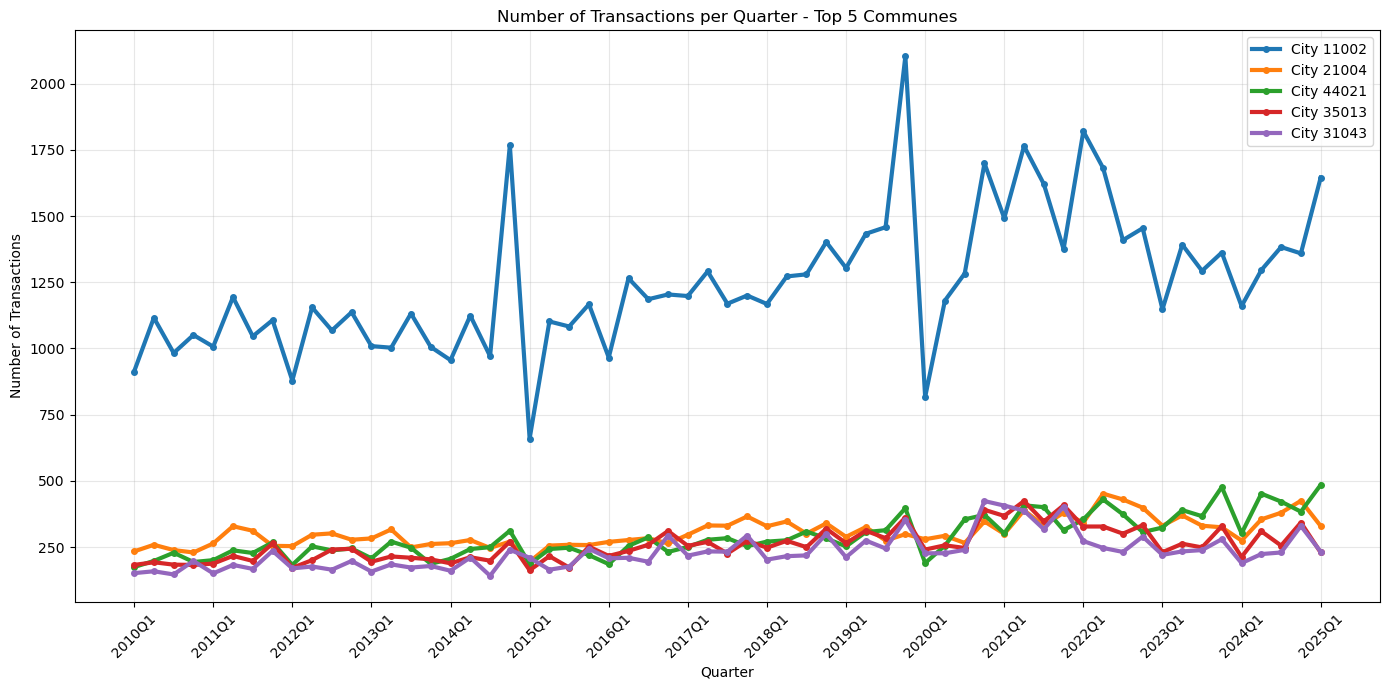

In [100]:
def plot_top_transactions(df, top_n=5, remove_outlier=False):
    """
    """
    commune_totals = df.groupby('refnis')['nombre transactions'].sum().sort_values(ascending=False)
    top_communes = commune_totals.head(top_n).index
    
    plt.figure(figsize=(14, 7))

    if remove_outlier:
        top_communes = top_communes[1:]
        
    for refnis in top_communes:
        commune_data = df[df['refnis'] == refnis]
        plt.plot(commune_data['quarter'], commune_data['nombre transactions'], 
                label=f'City {refnis}', marker='o', linewidth=3, markersize=4)
    
    plt.title(f'Number of Transactions per Quarter - Top {top_n} Communes')
    plt.xlabel('Quarter')
    plt.ylabel('Number of Transactions')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Show fewer x-axis labels for readability
    ax = plt.gca()
    ax.set_xticks(ax.get_xticks()[::4])
    
    plt.tight_layout()
    return plt

def plot_top_median_price(df, top_n=5, remove_outlier=False):
    """Plot median price for top N cities by total transactions"""
    # Use same top cities as transactions
    commune_totals = df.groupby('refnis')['nombre transactions'].sum().sort_values(ascending=False)
    top_communes = commune_totals.head(top_n).index
    
    plt.figure(figsize=(14, 7))

    if remove_outlier:
        top_communes = top_communes[1:]
    
    for refnis in top_communes:
        commune_data = df[df['refnis'] == refnis]
        plt.plot(commune_data['quarter'], commune_data['prix médian(€)'], 
                label=f'City {refnis}', marker='o', linewidth=3, markersize=4)
    
    plt.title(f'Median Price (€) per Quarter - Top {top_n} Communes')
    plt.xlabel('Quarter')
    plt.ylabel('Median Price (€)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt

plot_top_transactions(df_all_appartments, 5, False)

Bonus question: can you also visualize the data on a map? (spatial units available here: https://statbel.fgov.be/fr/open-data/secteurs-statistiques-2024)

In [25]:
df_geometry.iloc[1,-1]

b'\x00\x01\x8az\x00\x00\x00\x89A\xe0\xfb\xf9\x01A\x80St\xa4\x9aC\x0bA\x00\xde\x02\to(\x02A\x80\xd3\xbc\xe3\xcez\x0bA|\x06\x00\x00\x00\x01\x00\x00\x00i\x03\x00\x00\x00\x01\x00\x00\x00,\x00\x00\x00\x00\xbc\x96\x10\x99\'\x02A\x80St\xa4\x9aC\x0bA\x00\x82\xe2G\x98\'\x02A\x80c]\\\x9bC\x0bA\x00\x1b\r`2\'\x02A\x80}\x1d\xb8\xf8C\x0bA\x007\x1a@\xe8#\x02A\x80\xb47xVH\x0bA\x007\x1a@\xd7\x1f\x02A\x80}\x1d\xb8\x99M\x0bA\x00\x1b\r`\xbf\x1d\x02A\x80+\xf6\x17\xfeO\x0bA\x00R\' \xd1\x1a\x02A\x00G\x03\xf8\xd1S\x0bA\x00R\' N\x18\x02A\x00\xd0DX6V\x0bA\x00\x00\x00\x80\x8a\x16\x02A\x00G\x03\xf8._\x0bA\x00\xe5\xf2\x9f\x00\x16\x02A\x80+\xf6\x17Kb\x0bA\x00\xa5N\xc0\xe9\x15\x02A\x80b\x10\xd8\x9bc\x0bA\x007\x1a@\xec\x12\x02A\x00G\x03\xf8\xe5f\x0bA\x00\x1b\r`\xa6\x10\x02A\x80\xebQ8xi\x0bA\x00\xe5\xf2\x9f\'\x0f\x02A\x80\xebQ84k\x0bA\x007\x1a@\xbd\x07\x02A\x80}\x1d\xb86h\x0bA\x00\x1b\r`\x83\x06\x02A\x00G\x03\xf8\xacg\x0bA\x00\x00\x00\x80`\x05\x02A\x00\xd0DXUh\x0bA\x00\x89A\xe0L\x04\x02A\x00\x99*\x98\x87i\x0bA\x007\x1

In [29]:
print(df_geometry['geometry'].dtype)
print(df_geometry['geometry'].head())

corrupt_rows = df_geometry['geometry'].apply(lambda x: isinstance(x, str) and not x.startswith('01'))
print(df_geometry[corrupt_rows])

object
0    b"\x00\x01\x8az\x00\x00\x00\x00\x00\x80dm\x02A...
1    b'\x00\x01\x8az\x00\x00\x00\x89A\xe0\xfb\xf9\x...
2    b'\x00\x01\x8az\x00\x00\x00\x89A\xe06P\x03A\x8...
3    b'\x00\x01\x8az\x00\x00\x00\x02\x9a\x08\xe8<\x...
4    b"\x00\x01\x8az\x00\x00\x00\x1b\r`xN\x03A\x80\...
Name: geometry, dtype: object
Empty DataFrame
Columns: [refnis, commune, geometry]
Index: []


cannot easily read bytes with geopandas, moving to geojson file

In [78]:
response = requests.get("https://statbel.fgov.be/sites/default/files/files/opendata/Statistische%20sectoren/sh_statbel_statistical_sectors_31370_20240101.geojson.zip")
zip_file = zipfile.ZipFile(BytesIO(response.content))
files = zip_file.namelist()
files

['sh_statbel_statistical_sectors_31370_20240101.geojson/Licence open data_FR.pdf',
 'sh_statbel_statistical_sectors_31370_20240101.geojson/Licence open data_NL.pdf',
 'sh_statbel_statistical_sectors_31370_20240101.geojson/sh_statbel_statistical_sectors_31370_20240101.geojson',
 'sh_statbel_statistical_sectors_31370_20240101.geojson/sh_statbel_statistical_sectors_31370_20240101-readme-de.doc',
 'sh_statbel_statistical_sectors_31370_20240101.geojson/sh_statbel_statistical_sectors_31370_20240101-readme-en.doc',
 'sh_statbel_statistical_sectors_31370_20240101.geojson/sh_statbel_statistical_sectors_31370_20240101-readme-fr.doc',
 'sh_statbel_statistical_sectors_31370_20240101.geojson/sh_statbel_statistical_sectors_31370_20240101-readme-nl.doc']

In [79]:
geojson_full_path = [f for f in files if f.endswith(".geojson")][0]
geojson_name = os.path.basename(geojson_full_path)
with open(os.path.join("temp", geojson_name), "wb") as f_out:
    f_out.write(zip_file.read(geojson_full_path))

In [84]:
gdf = gpd.read_file(os.path.join("temp", geojson_name))
gdf = gdf[["cd_munty_refnis", "tx_sector_descr_fr", "geometry"]]
gdf.columns = ["refnis", "commune", "geometry"]
gdf.refnis = gdf.refnis.astype(int)
gdf

,refnis,commune,geometry
0,11001,AARTSELAAR-CENTRUM,"MULTIPOLYGON (((151660.031 203013.606, 151850...."
1,11001,DE LEEUWERIK,"MULTIPOLYGON (((151748.5 203170.481, 151736.12..."
2,11001,BUERSTEDE,"MULTIPOLYGON (((150636.359 202981.934, 150530...."
3,11001,YSSELAAR,"MULTIPOLYGON (((151584.547 203829.809, 151526...."
4,11001,KLEINE GRIPPE,"MULTIPOLYGON (((151748.5 203170.481, 151731.56..."
...,...,...,...
19790,93090,BOIS DE NISMES,"MULTIPOLYGON (((166383.594 80209.168, 166380.9..."
19791,93090,DOURBES-CENTRE,"MULTIPOLYGON (((165761.109 86583.363, 165757.1..."
19792,93090,DOURBES ROUTE DE MARIEMBOURG,"MULTIPOLYGON (((165761.109 86583.363, 165703.7..."
19793,93090,LORET,"MULTIPOLYGON (((165906.422 86861.793, 165861.8..."


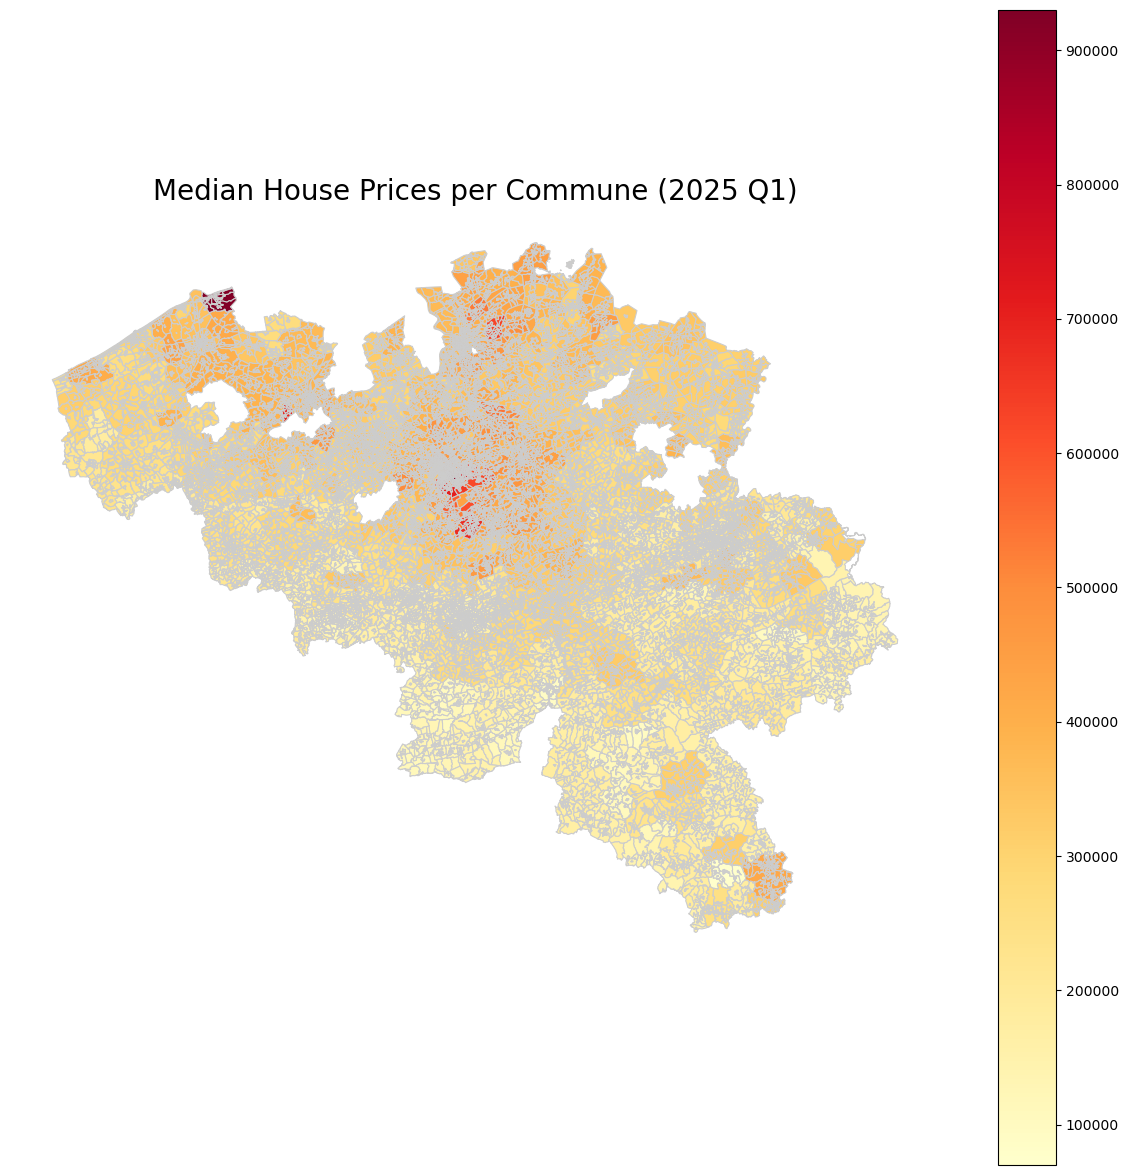

In [88]:
latest_year = 2025
latest_quarter = 'Q1'
filtered_sales = df_all_houses[
    (df_all_houses['année'] == latest_year) &
    (df_all_houses['période'] == latest_quarter)
]

merged_gdf = gdf.merge(filtered_sales, on='refnis', how='inner')

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_gdf.plot(
    column='prix médian(€)',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }
)


ax.set_title(f'Median House Prices per Commune ({latest_year} {latest_quarter})', fontsize=20)
ax.set_axis_off()

plt.show()

Bonus question: Can you make the visualizations interactive for the user? <br> 
**Not enough time to make a web app, RESTFUL api or pyleaflet, just using input function for simplicity

Please insert the year of your search:  2019
Please insert the quarter (Q1, Q2, Q3 or Q4):  Q3
Please insert the property type (house, attached, dettached or appartment):  appartment


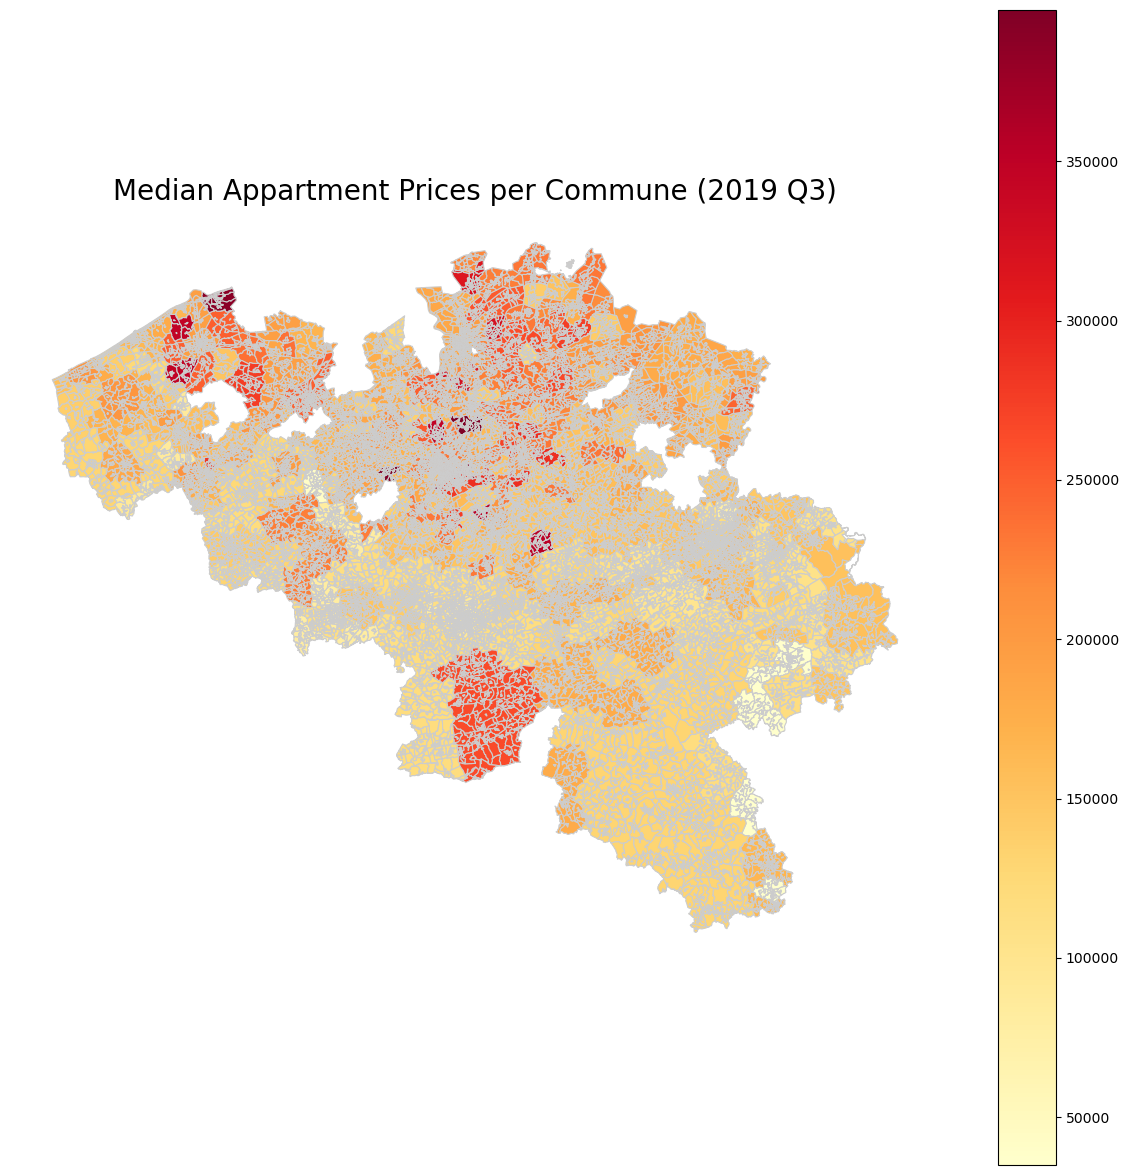

In [96]:
def plot_user_input(input_year, input_quarter, property_type):
    if property_type == "house":
        selected_df = df_all_houses
    elif property_type == "attached":
        selected_df = df_attached_houses
    elif property_type == "dettached":
        selected_df = df_dettached_houses
    elif property_type == "appartment":
        selected_df = df_all_appartments
    else:
        raise Exception(f"InvalidPropertyType{property_type}")
    filtered_sales = selected_df[
        (selected_df['année'] == input_year) &
        (selected_df['période'] == input_quarter)
    ]
    
    merged_gdf = gdf.merge(filtered_sales, on='refnis', how='inner')
    
    # 4. Create the heatmap plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    merged_gdf.plot(
        column='prix médian(€)',
        cmap='YlOrRd',
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=True,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",
        }
    )
    
    
    ax.set_title(f'Median {property_type.title()} Prices per Commune ({input_year} {input_quarter})', fontsize=20)
    ax.set_axis_off()
    
    plt.show()

user_year = int(input("Please insert the year of your search: "))
user_quarter = input("Please insert the quarter (Q1, Q2, Q3 or Q4): ")
user_property_type = input("Please insert the property type (house, attached, dettached or appartment): ")
plot_user_input(user_year, user_quarter, user_property_type)

## Price corrector

### Base question  (without modeling)

In this simple approach we will just apply the % change from t0 to t1 for the same location to the input price

In [71]:
def t1_price(input_price, t0_year, t0_quarter,  refnis, df):
    """
    """
    assert t0_year > 2010
    assert not (t0_year == 2025 and t0_quarter != "Q1")
    assert type(input_price) is int or type(input_price) is float
    assert type(t0_year) is int
    assert type(refnis) is int
    refnis_t0_price = df[(df["refnis"]== refnis) & (df["année"]== t0_year) & (df["période"]== t0_quarter)]["prix médian(€)"]
    refnis_t1_price = df.iloc[refnis_t0_price.index + 1,:]["prix médian(€)"] # assuming index +1 belongs to same refnis/commune
    refnis_t0_price = refnis_t0_price.values[0]
    refnis_t1_price = refnis_t1_price.values[0] 
    return round(input_price * (refnis_t1_price / refnis_t0_price), 2)

def price_corrector(input_price, t0_year, t0_quarter,  refnis, property_type):
    assert type(property_type) is str
    if property_type == "house":
        return t1_price(input_price, t0_year, t0_quarter,  refnis, df_all_houses)
    elif property_type == "attached":
        return t1_price(input_price, t0_year, t0_quarter,  refnis, df_attached_houses)
    elif property_type == "dettached":
        return t1_price(input_price, t0_year, t0_quarter,  refnis, df_dettached_houses)
    elif property_type == "appartment":
        return t1_price(input_price, t0_year, t0_quarter,  refnis, df_all_appartments)
    raise Exception(f"InvalidPropertyType{property_type}")

In [72]:
t1_price(190_000, 2015, "Q2",11002, df_all_appartments)

194570.45

In [77]:
price_corrector(190_000, 2015, "Q2",11002, "dettached")

196206.67

### Bonus question: 

Can you <b>forecast</b> the price for future quarter(s) not provided in the dataset?

Machine Learning approach (RandomForests)

Note: Due to time constraints, the house data is the only dataset used, same exact procedure can be followed for other cases.

In [114]:
df_all_houses = df_all_houses.sort_values(by=['refnis', 'année', 'quarter']) #just as prevention, already sorted from source

df_all_houses['nombre_transactions_t-1'] = df_all_houses.groupby('refnis')['nombre transactions'].shift(1)

df_all_houses.dropna(inplace=True)

# Define features (X) and target (y)
X = df_all_houses[['nombre_transactions_t-1']]
y = df_all_houses['nombre transactions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

eval_refnis = 93090

last_known_transaction = df_all_houses[df_all_houses['refnis'] == eval_refnis]['nombre transactions'].iloc[-1]

last_known_data = [[last_known_transaction]]


forecasted_transactions_t1 = model.predict(last_known_data)

print(f"Forecasted No. of transactions for the next quarter t1) for commune with refnis code {eval_refnis}: {forecasted_transactions_t1[0]:.2f}")

Forecasted No. of transactions for the next quarter t1) for commune with refnis code 93090: 26.66


C:\Users\luis_\.conda\envs\gisprog\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Evaluating the model

In [115]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.2f}")

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.round(2)})

results_df.head()

Mean Squared Error (MSE): 262.18
R-squared: 0.69


,Actual,Predicted
24443,77.0,54.40
24444,65.0,76.93
24445,59.0,64.26
24446,85.0,57.00
24447,90.0,82.83
